In [49]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

WINDOW_SIZE = 30
HORIZON = 30

# Load data
df_raw = pd.read_csv("harga_beras_premium.csv")
df_raw["Tanggal"] = pd.to_datetime(df_raw["Tanggal"], dayfirst=True)
df = df_raw.pivot(index="Tanggal", columns="Provinsi", values="Harga").sort_index()
df = df.fillna(method="ffill")

# Hitung fitur tambahan per provinsi
def add_features(df):
    new_df = df.copy()
    for col in df.columns:
        new_df[f"{col}_delta"] = df[col].diff()
        new_df[f"{col}_rolling7"] = df[col].rolling(7).mean()
    new_df["calweek"] = df.index.isocalendar().week
    new_df["calweek_sin"] = np.sin(2 * np.pi * new_df["calweek"] / 52)
    new_df["calweek_cos"] = np.cos(2 * np.pi * new_df["calweek"] / 52)
    return new_df.drop(columns="calweek")

df_feat = add_features(df).dropna()

# Split data
df_feat = df_feat.loc["2024-01-20":"2025-05-16"]
train_df = df_feat.loc[:"2024-08-31"]
val_df = df_feat.loc["2024-09-01":"2025-01-31"]
test_df = df_feat.loc["2025-02-01":]


/tmp/ipykernel_11080/2448970282.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


In [50]:
from sklearn.preprocessing import StandardScaler

def create_multinode_tensor(df, window_size, horizon, base_columns):
    features = df.columns.tolist()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(len(scaled) - window_size - horizon):
        x_window = scaled[i:i+window_size]
        y_future = scaled[i+window_size:i+window_size+horizon]
        
        # Get the target values (province prices only)
        base_col_indices = [df.columns.get_loc(col) for col in base_columns]
        y_target = y_future[:, base_col_indices]
        
        # For feature input, reshape without trying to interpret structure
        # Just keep window, features dimension and let the model handle it
        x_window = x_window.reshape(window_size, -1)
        
        # Add channel dimension for GCN
        x_window_expanded = np.expand_dims(x_window, axis=1)
        
        y_target = y_target.T  # shape: (num_nodes, horizon)
        
        X.append(x_window_expanded)
        y.append(y_target)

    return (
        torch.tensor(np.array(X), dtype=torch.float32),  # shape: (samples, 1, window, features)
        torch.tensor(np.array(y), dtype=torch.float32),  # shape: (samples, nodes, horizon)
        scaler
    )

# Only use province names, not the derived features
base_columns = df.columns.tolist()  # province names only
X_train, y_train, scaler = create_multinode_tensor(train_df, WINDOW_SIZE, HORIZON, base_columns)
X_val, y_val, _ = create_multinode_tensor(val_df, WINDOW_SIZE, HORIZON, base_columns)
X_test, y_test, _ = create_multinode_tensor(test_df, WINDOW_SIZE, HORIZON, base_columns)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: torch.Size([159, 30, 1, 116])
y_train: torch.Size([159, 38, 30])


In [51]:
from torch_geometric.utils import dense_to_sparse

def build_edge_index(df, threshold=0.5):
    base_df = df[df.columns.intersection(base_columns)]
    corr = base_df.corr().abs()
    corr[corr < threshold] = 0
    edge_index, _ = dense_to_sparse(torch.tensor(corr.values, dtype=torch.float32))
    return edge_index

edge_index = build_edge_index(train_df)
print("edge_index:", edge_index.shape)


edge_index: torch.Size([2, 694])


In [52]:
import torch.nn as nn
# from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv


class GCN_GRU_Multihorizon(nn.Module):
    def __init__(self, num_nodes, in_feats, hidden_dim, out_horizon, edge_index):
        super().__init__()
        self.edge_index = edge_index
        # self.gcn = GCNConv(1, hidden_dim)  # Change to process 1 feature per node
        self.gcn = GATConv(1, hidden_dim//4, heads=4, concat=True, dropout=0.3)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_horizon)
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        # x shape: (batch, 1, window, features) from create_multinode_tensor function
        B, C, T, F = x.shape
        
        # Reshape to work with our architecture
        x = x.squeeze(1)  # Remove channel dim, now: (batch, window, features)
        
        # Create a list to store batch outputs
        batch_output = []
        
        for b in range(B):
            # Process each time step with GCN
            time_outputs = []
            
            for t in range(T):
                # Get features at this time step
                xt = x[b, t]  # (features)
                
                # Instead of reshaping features to nodes, we create a feature embedding per node
                # We can do this by modeling each feature as a separate node with a 1D feature
                features_as_nodes = xt.view(-1, 1)  # Shape: (F, 1)
                
                # If we have more features than expected nodes, truncate or use a subset
                # If we have fewer features than nodes, we'll pad with zeros
                if F > self.num_nodes:
                    # Take a subset - use strided sampling to select evenly across all features
                    stride = F // self.num_nodes
                    indices = torch.arange(0, self.num_nodes) * stride
                    node_features = features_as_nodes[indices]
                elif F < self.num_nodes:
                    # Pad with zeros
                    node_features = torch.zeros(self.num_nodes, 1, device=x.device)
                    node_features[:F] = features_as_nodes
                else:
                    node_features = features_as_nodes
                
                # Apply GCN - each node now has a single feature
                xt = self.gcn(node_features, self.edge_index)  # (num_nodes, hidden_dim)
                xt = xt + node_features
                time_outputs.append(xt)
            
            # Stack all time outputs
            node_features = torch.stack(time_outputs, dim=1)  # (num_nodes, T, hidden_dim)
            
            # Process each node sequence with GRU
            node_outputs = []
            for n in range(self.num_nodes):
                node_seq = node_features[n]  # (T, hidden_dim)
                out, _ = self.gru(node_seq.unsqueeze(0))  # Add batch dim
                out = self.fc(out[:, -1])  # Use last output for prediction
                node_outputs.append(out)
            
            # Stack all node outputs for this batch item
            batch_output.append(torch.cat(node_outputs, dim=1))  # (1, num_nodes*out_horizon)
        
        # Reshape to (batch, num_nodes, out_horizon)
        result = torch.cat(batch_output, dim=0)
        return result.view(B, self.num_nodes, -1)  # (batch, num_nodes, out_horizon)


In [53]:
from sklearn.metrics import mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN_GRU_Multihorizon(
    num_nodes=len(base_columns),
    in_feats=X_train.shape[-1],
    hidden_dim=64,
    out_horizon=HORIZON,
    edge_index=edge_index.to(device)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.HuberLoss(delta=5.0) 

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val)
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")


Epoch 1: Train Loss = 0.3741 | Val Loss = 0.5483
Epoch 10: Train Loss = 0.3526 | Val Loss = 0.5463
Epoch 20: Train Loss = 0.3449 | Val Loss = 0.5509
Epoch 30: Train Loss = 0.3416 | Val Loss = 0.5507
Epoch 40: Train Loss = 0.3387 | Val Loss = 0.5474
Epoch 50: Train Loss = 0.3356 | Val Loss = 0.5458
Epoch 60: Train Loss = 0.3320 | Val Loss = 0.5438
Epoch 70: Train Loss = 0.3267 | Val Loss = 0.5422
Epoch 80: Train Loss = 0.3185 | Val Loss = 0.5411
Epoch 90: Train Loss = 0.3086 | Val Loss = 0.5418
Epoch 100: Train Loss = 0.2999 | Val Loss = 0.5452
Epoch 110: Train Loss = 0.2957 | Val Loss = 0.5493
Epoch 120: Train Loss = 0.2879 | Val Loss = 0.5513
Epoch 130: Train Loss = 0.2814 | Val Loss = 0.5518
Epoch 140: Train Loss = 0.2754 | Val Loss = 0.5526
Epoch 150: Train Loss = 0.2717 | Val Loss = 0.5538
Epoch 160: Train Loss = 0.2667 | Val Loss = 0.5547
Epoch 170: Train Loss = 0.2652 | Val Loss = 0.5555
Epoch 180: Train Loss = 0.2617 | Val Loss = 0.5557
Epoch 190: Train Loss = 0.2604 | Val Loss 

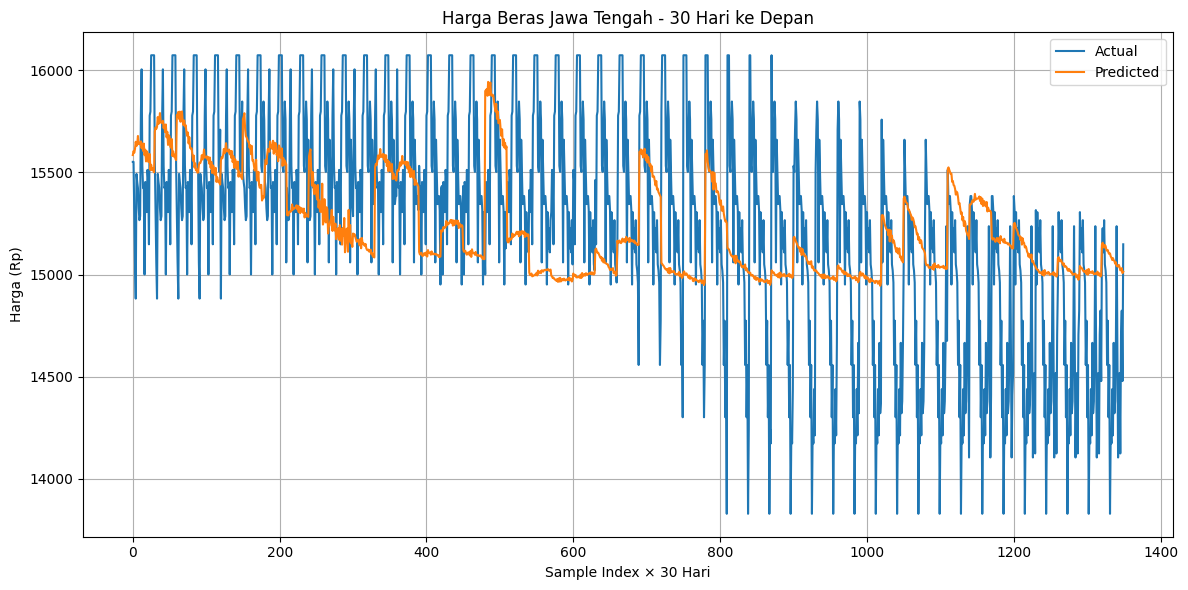

In [54]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    pred_test = model(X_test).cpu().numpy()
    true_test = y_test.cpu().numpy()

# Get the number of features the scaler was fitted on
n_features = len(train_df.columns)
prov_idx = base_columns.index("Jawa Tengah")  # example province
scaler_index = train_df.columns.get_loc("Jawa Tengah")

# Reshape predictions and true values
pred_flat = pred_test[:, prov_idx, :].flatten()  # Flatten to 1D array
true_flat = true_test[:, prov_idx, :].flatten()  # Flatten to 1D array

# Create zero matrices with the right dimensions
pred_matrix = np.zeros((len(pred_flat), n_features))
true_matrix = np.zeros((len(true_flat), n_features))

# Insert values at the correct column index
pred_matrix[:, scaler_index] = pred_flat
true_matrix[:, scaler_index] = true_flat

# Inverse transform
pred_jateng = scaler.inverse_transform(pred_matrix)[:, scaler_index]
true_jateng = scaler.inverse_transform(true_matrix)[:, scaler_index]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_jateng, label="Actual")
plt.plot(pred_jateng, label="Predicted")
plt.title("Harga Beras Jawa Tengah - 30 Hari ke Depan")
plt.xlabel("Sample Index × 30 Hari")
plt.ylabel("Harga (Rp)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# pred_test and true_test are numpy arrays from the previous cell
# scaler, base_columns, and train_df are available from previous cells

# Number of features the scaler was originally fitted on
n_features_scaler = scaler.n_features_in_

all_true_inv = []
all_pred_inv = []

num_nodes = pred_test.shape[1] # Number of provinces

for i in range(num_nodes):
    province_name = base_columns[i]
    # Get the column index of this province in the original DataFrame (train_df) that the scaler was fit on
    try:
        scaler_col_idx = train_df.columns.get_loc(province_name)
    except KeyError:
        print(f"Warning: Province {province_name} not found in train_df columns. Skipping this province for metrics.")
        continue

    # Extract scaled predictions and true values for the current province
    # Flatten across samples and horizon: (num_samples * horizon,)
    node_pred_scaled_flat = pred_test[:, i, :].flatten()
    node_true_scaled_flat = true_test[:, i, :].flatten()

    # Create zero matrices with the shape (num_flattened_points, n_features_scaler)
    # This is needed because the scaler expects input with the original number of features
    pred_matrix_for_inv = np.zeros((len(node_pred_scaled_flat), n_features_scaler))
    true_matrix_for_inv = np.zeros((len(node_true_scaled_flat), n_features_scaler))

    # Place the scaled values of the current province into the correct column
    pred_matrix_for_inv[:, scaler_col_idx] = node_pred_scaled_flat
    true_matrix_for_inv[:, scaler_col_idx] = node_true_scaled_flat
    
    # Inverse transform
    node_pred_inv = scaler.inverse_transform(pred_matrix_for_inv)[:, scaler_col_idx]
    node_true_inv = scaler.inverse_transform(true_matrix_for_inv)[:, scaler_col_idx]
    
    all_pred_inv.append(node_pred_inv)
    all_true_inv.append(node_true_inv)

# Concatenate inverse-transformed values from all provinces
if not all_true_inv or not all_pred_inv:
    print("Error: No data to calculate metrics. Check province names and data.")
else:
    final_true_values = np.concatenate(all_true_inv)
    final_pred_values = np.concatenate(all_pred_inv)

    # Calculate metrics
    r2 = r2_score(final_true_values, final_pred_values)
    rmse = np.sqrt(mean_squared_error(final_true_values, final_pred_values))
    mae = mean_absolute_error(final_true_values, final_pred_values)

    # MAPE calculation (robust to zeros in true values)
    non_zero_mask = final_true_values != 0
    if np.any(non_zero_mask):
        mape = np.mean(np.abs((final_true_values[non_zero_mask] - final_pred_values[non_zero_mask]) / final_true_values[non_zero_mask])) * 100
    else:
        mape = np.nan # All true values are zero, MAPE is undefined or could be 0 if preds are also 0.

    print(f"Overall Test Metrics:")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

Overall Test Metrics:
R2 Score: 0.6527
RMSE: 1068.05
MAE: 493.56
MAPE: 2.90%
